<a href="https://colab.research.google.com/github/TimofeiMenshikov/figures_classificator/blob/main/figures_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортирование библиотек для генерации датесета, удаления датасета

In [125]:
import random
import csv
from PIL import Image, ImageDraw
import os
import shutil

Удаление датасета

In [126]:
folders_to_remove = [
    'dataset/circle',
    'dataset/triangle',
    'dataset/rectangle'
]

for folder_path in folders_to_remove:
    try:
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
            print(f"Папка {folder_path} успешно удалена")
        else:
            print(f"Папка {folder_path} не существует")
    except Exception as e:
        print(f"Ошибка при удалении {folder_path}: {str(e)}")

Папка dataset/circle успешно удалена
Папка dataset/triangle успешно удалена
Папка dataset/rectangle успешно удалена


Создание датасета

In [127]:
dataset_size = 200

os.makedirs("dataset", exist_ok=True)
os.makedirs("dataset/rectangle", exist_ok=True)
os.makedirs("dataset/circle", exist_ok=True)
os.makedirs("dataset/triangle", exist_ok=True)


def generate_random_shape(width=128, height=128):
    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)

    # Случайные параметры
    shape = random.choice(["circle", "rectangle", "triangle"])
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    size = random.randint(70, 100)
    x0 = random.randint(10, width - size - 10)
    y0 = random.randint(10, height - size - 10)

    #is_filled = random.randint(0, 1) (есть возможность генерировать также незакрашенные фигуры, но пока нейросеть не может справиться с таким датасетом)
    is_filled = 1


    if (is_filled): fill = color
    else:           fill = "white"



    # Рисование
    if shape == "circle":
        draw.ellipse((x0, y0, x0 + size, y0 + size), fill = fill, outline = color)
    elif shape == "rectangle":
        draw.rectangle((x0, y0, x0 + size, y0 + size), fill= fill, outline = color)
    elif shape == "triangle":
        points = [
            (x0 + size//2, y0),
            (x0, y0 + size),
            (x0 + size, y0 + size)
        ]
        draw.polygon(points, fill = fill, outline = color)

    return image, shape

img = generate_random_shape()
how_many_figures = {"circle" : 0, "rectangle" : 0, "triangle" : 0}

for i in range(dataset_size):
    img, shape = generate_random_shape()

    how_many_figures[shape] += 1

    filename = f"shape_{i}.png"
    img.save(f"dataset/{shape}/{filename}")

img.save("random_shape.png")
print(how_many_figures)

{'circle': 66, 'rectangle': 59, 'triangle': 75}


Импорт библиотек для нейронной сети

In [128]:
from torchvision import datasets, transforms
import torch
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import random_split


Преобразование датасета для нейросети

In [129]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

])


dataset = datasets.ImageFolder(
    root='dataset',  # Путь к корневой папке с классами
    transform=transform
)


n_train = int(len(dataset) * 0.64)
n_valid = int(len(dataset) * 0.16)
n_test  = len(dataset) - n_train - n_valid

train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train, n_valid, n_test],
    generator=torch.Generator().manual_seed(42)  # Для воспроизводимости
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle = True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = 10,
    shuffle = True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 10,
    shuffle = True
)

Архитектура нейронной сети (Линейный классификатор)

In [144]:
class LinearImageClassifier(nn.Module):
    def __init__(self, input_size=64*64*3, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(

            nn.Linear(input_size, 512),  # 64*64*3 = 12288 входных нейронов → 512
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)  # Преобразует [batch, 3, 64, 64] → [batch, 3*64*64]
        x = self.layers(x)
        return x

Объявление модели (запустить для сброса весов)

In [145]:
#Параметры модели
input_size = (3, 64, 64)  # [каналы, высота, ширина]
num_classes = 3           # круг, квадрат, треугольник

model = LinearImageClassifier(input_size=3*64*64, num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Используется устройство: {device}")

loss_fn = nn.CrossEntropyLoss()  # Для классификации
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Или SGD

Используется устройство: cpu


Функция для получения accuracy для конкретной выборки

In [146]:
def get_accuracy(dataloader, model):

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(predicted)):
                correct += (predicted[i] == labels[i])
                total   += 1

    return float(100 * correct / total)

Списки для построения графиков ниже

In [147]:
train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

Обучение, валидация и сохранение модели

In [148]:
num_epochs = 10

for epoch in range(num_epochs):

    # Обучение
    model.train()

    train_loss = 0.0

    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_acc = get_accuracy(train_dataloader, model)
    print(f"Train Loss: {train_loss/len(train_dataloader):.4f}", "Train accuracy: ", train_acc)
    train_losses.append(train_loss/len(train_dataloader))
    train_accs.append(train_acc)


    # Валидация
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for val_batch in valid_dataloader:
            inputs, labels = val_batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += loss_fn(outputs, labels).item()

        valid_acc = get_accuracy(valid_dataloader, model)

        print(f"Val Loss: {val_loss/len(valid_dataloader):.4f}", "Valid accuracy: ", valid_acc)
        valid_losses.append(val_loss/len(valid_dataloader))
        valid_accs.append(valid_acc)

    print("Test accuracy: ", get_accuracy(test_dataloader, model))

# Сохранение
torch.save(model.state_dict(), "model.pth")

Train Loss: 0.9019 Train accuracy:  75.0
Val Loss: 0.5811 Valid accuracy:  75.0
Test accuracy:  77.5
Train Loss: 0.6181 Train accuracy:  78.90625
Val Loss: 0.4006 Valid accuracy:  78.125
Test accuracy:  87.5
Train Loss: 0.6172 Train accuracy:  81.25
Val Loss: 0.6712 Valid accuracy:  75.0
Test accuracy:  82.5
Train Loss: 0.5428 Train accuracy:  82.8125
Val Loss: 0.4122 Valid accuracy:  78.125
Test accuracy:  80.0
Train Loss: 0.4435 Train accuracy:  84.375
Val Loss: 0.3320 Valid accuracy:  84.375
Test accuracy:  85.0
Train Loss: 0.3698 Train accuracy:  85.15625
Val Loss: 0.2277 Valid accuracy:  90.625
Test accuracy:  90.0
Train Loss: 0.3392 Train accuracy:  92.1875
Val Loss: 0.2675 Valid accuracy:  93.75
Test accuracy:  87.5
Train Loss: 0.3108 Train accuracy:  94.53125
Val Loss: 0.1932 Valid accuracy:  96.875
Test accuracy:  92.5
Train Loss: 0.2635 Train accuracy:  88.28125
Val Loss: 0.4645 Valid accuracy:  84.375
Test accuracy:  77.5
Train Loss: 0.2450 Train accuracy:  93.75
Val Loss: 0

CrossEntropyLoss для train и valid среднаяя по эпохе

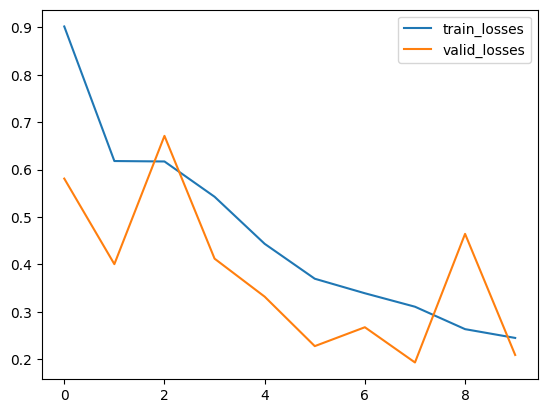

In [149]:

plt.plot(train_losses, label = "train_losses")
plt.plot(valid_losses, label = "valid_losses")

plt.legend()
plt.show()



Accuracy для train и valid в %

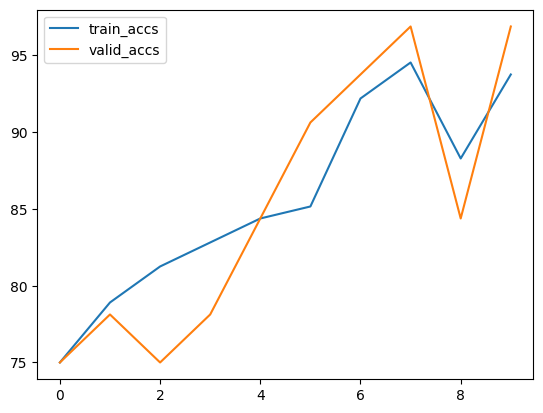

In [150]:
plt.plot(train_accs, label = "train_accs")
plt.plot(valid_accs, label = "valid_accs")

plt.legend()
plt.show()


In [151]:
print("test",  get_accuracy(test_dataloader,  model), "%")
print("train", get_accuracy(train_dataloader, model), "%")
print("valid", get_accuracy(valid_dataloader, model), "%")

test 95.0 %
train 97.65625 %
valid 96.875 %
